In [1]:
import cv2 as cv
import numpy as np
import nibabel as nib
from tqdm import tqdm
from itertools import product
from perlin_numpy import generate_perlin_noise_3d

import matplotlib.pyplot as plt

In [4]:
# load previously synthesized labels and images
label_path = '/om2/user/ckapoor/generative_model/outputs/training_labels/stack_0000/stack_0000_0000_v20.nii.gz'
img_path = '/om2/user/ckapoor/generative_model/outputs/training_images/stack_0000/stack_0000_0000_v20.nii.gz'

In [5]:
img, label = nib.load(img_path).get_fdata(), nib.load(label_path).get_fdata()

Text(0.5, 1.0, 'synthetic label, slice: 30')

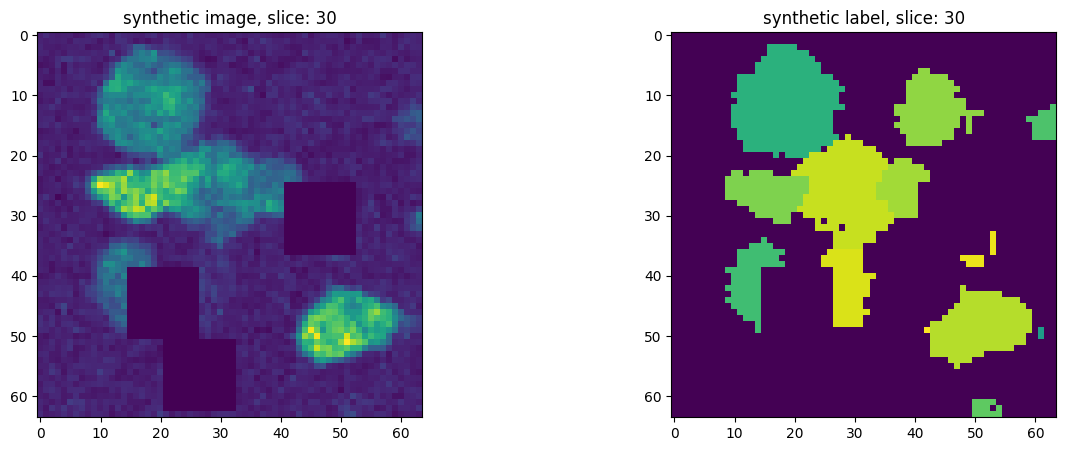

In [8]:
view_sl = 30

_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img[view_sl,...])
ax[0].set_title(f"synthetic image, slice: {view_sl}")
ax[1].imshow(label[view_sl,...])
ax[1].set_title(f"synthetic label, slice: {view_sl}")

# generate synthetic labels

In [9]:
def calculate_distance(center_coords, grid_size=128):
    # submit PR to repo?
    # Assign n_vox x n_spheres array:
    distances = np.zeros((grid_size**3, len(center_coords)))

    # list all voxel indices
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    z = np.arange(grid_size)
    xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
    vox_coord = np.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=1)

    # computes distances using broadcasting
    distances = np.sqrt(np.sum((vox_coord[:, np.newaxis, :] - center_coords)**2, axis=2))

    return distances

In [57]:
def initial_label_generator(grid_size=128, r_mean=12):

    Nz, Ny, Nx = (grid_size,) * 3
    
    x = np.arange(0, grid_size, 2*r_mean)[1:-1]
    Z, Y, X = np.meshgrid(x, x, x, indexing='ij')  # center coordinates
    
    # Randomly translate centers:
    points = np.stack(
        [Z.flatten(), Y.flatten(), X.flatten()]
    ).T # center coordinates flattened
    points = (points).astype(np.float32) 
    points_perturbed = points + .5*r_mean*np.random.uniform(-1,1,points.shape)
    
    # Randomly drop between 0--33% of spheres:
    ind = np.arange(len(points_perturbed))  # index of individual point
    np.random.shuffle(ind)  # randomly shuffle indices
    
    ind_keep = ind[:np.random.randint(2*len(ind)//3,len(ind))]  # drop indices
    points_perturbed_kept = points_perturbed[ind_keep]  # drop spheres
    
    # Randomly scale radii
    rads = r_mean * np.random.uniform(.6, 1.2, len(points))  # randomly scale
    rads_kept = rads[ind_keep]  # randomly drop radii

    # Compute n_vox x n_spheres matrix:
    dist_mtx = calculate_distance(points_perturbed_kept)

    # Sample perlin noise
    noise_sample = generate_perlin_noise_3d((Nz, Ny, Nx), res=(8, 8, 8))

    # Corrupt distance matrix:
    corr_dist_mtx = (
        dist_mtx + 0.9 * r_mean * noise_sample.flatten()[:, np.newaxis]
    )

    # Label assignment
    labelmap = np.zeros(grid_size**3, dtype=np.uint16)  # initialize
    for j in tqdm(range(dist_mtx.shape[0])): 
        finder = np.where(corr_dist_mtx[j, :] < rads_kept)[0]
        if len(finder) > 0:
            # in case of match with more than label, assign to closest:
            value = finder[np.argmin(corr_dist_mtx[j, finder])]
            labelmap[j] = value + 1

    labelmap = np.reshape(labelmap, (grid_size, grid_size, grid_size))
    return labelmap

In [66]:
# initialize random seed 
np.random.seed(6969)
label = initial_label_generator(grid_size=128, r_mean=12)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2097152/2097152 [00:06<00:00, 319002.69it/s]


In [68]:
import nibabel as nib

# steerable, 2D gaussian filter

kernel functions:
\begin{align*}
    G &= e^{-(x^2 + y^2)}\\
    G^{0^\circ}_{1} &= \frac{\partial}{\partial x}e^{-(x^2+y^2)} = -2x e^{-(x^2+y^2)}\\
    G^{90^\circ}_{1} &= \frac{\partial}{\partial y}e^{-(x^2+y^2)} = -2y e^{-(x^2+y^2)}
\end{align*}

In [43]:
# define gaussian filter kernels at 0 and 90 degrees
g = lambda x, y: np.exp(-(x**2 + y**2))
g_0 = lambda x, y: -2*x*g(x,y)
g_90 = lambda x, y: -2*y*g(x,y)

In [41]:
# define filter size and conv indices
filter_size = 4
x_index, y_index = np.meshgrid(np.arange(-filter_size, filter_size + 1), np.arange(-filter_size, filter_size + 1))
x_index = x_index.reshape((-1, 1))
y_index = y_index.reshape((-1, 1))

In [44]:
# get kernels
gauss_kernel = g(x_index, y_index).reshape((filter_size*2 + 1, filter_size*2 + 1))
gauss_kernel_0 = g_0(x_index, y_index).reshape((filter_size*2 + 1, filter_size*2 + 1))
gauss_kernel_90 = g_90(x_index, y_index).reshape((filter_size*2 + 1, filter_size*2 + 1))

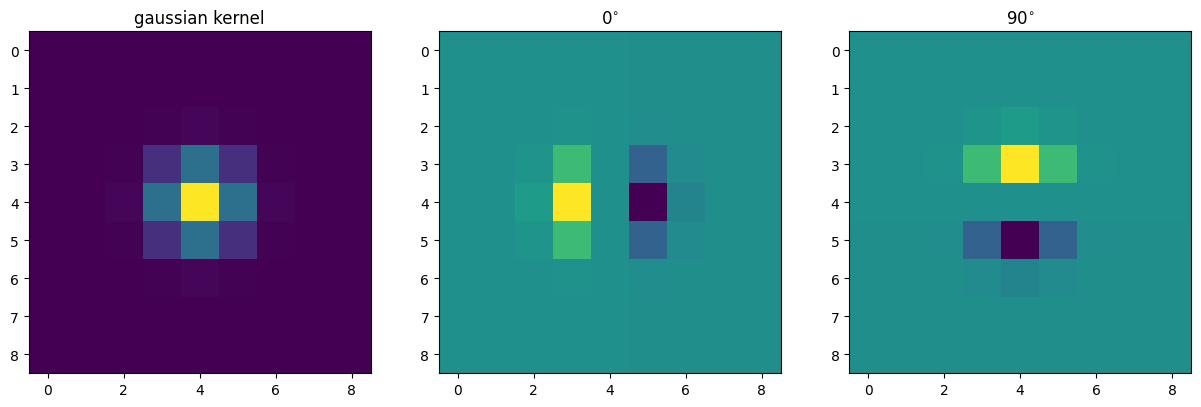

In [47]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(gauss_kernel)
ax[0].set_title("gaussian kernel")
ax[1].imshow(gauss_kernel_0)
ax[1].set_title("$0^{\circ}$")
ax[2].imshow(gauss_kernel_90)
ax[2].set_title("$90^{\circ}$");

In [89]:
# convolve label with filters
conv_gauss = cv.filter2D(label[30,:,:,], ddepth=-1, kernel=gauss_kernel)
conv_gauss_0 = cv.filter2D(label[30,:,:,], ddepth=-1, kernel=gauss_kernel_0)
conv_gauss_90 = cv.filter2D(label[30,:,:,], ddepth=-1, kernel=gauss_kernel_90)

Text(0.5, 1.0, '$90^{\\circ}$ filtered image')

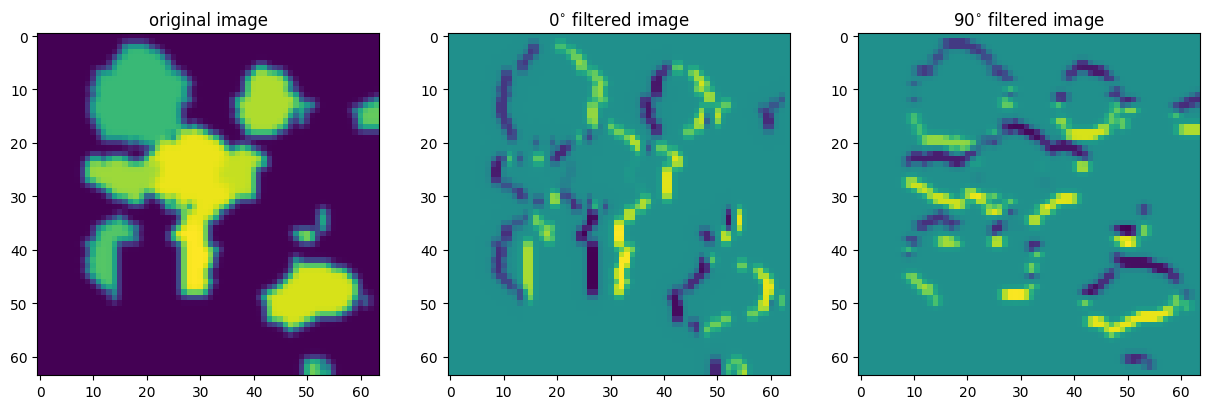

In [90]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(conv_gauss)
ax[0].set_title("original image")
ax[1].imshow(conv_gauss_0)
ax[1].set_title("$0^{\circ}$ filtered image")
ax[2].imshow(conv_gauss_90)
ax[2].set_title('$90^{\circ}$ filtered image')

we want to implement the following kernel:
\begin{equation*}
    G(x, y, z) = \frac{1}{(2\pi\sigma^2)^{3/2}}\cdot\exp\left(-\frac{x^2 + y^2 + z^2}{2\sigma^2}\right)
\end{equation*}

hence, for an arbitrary angular position $\alpha, \beta, \gamma$, we have:
\begin{equation*}
    G_{\alpha, \beta, \gamma} = G_x\cos{\theta_x} + G_y\cos{\theta_y} + G_z\cos{\theta_z}
\end{equation*}

In [62]:
import numpy as np
from scipy.ndimage import gaussian_filter

def gaussian_3d_kernel(size, sigma):
    x, y, z = np.meshgrid(np.linspace(-1, 1, size[0]), 
                          np.linspace(-1, 1, size[1]), 
                          np.linspace(-1, 1, size[2]), indexing='ij')
    distance = np.sqrt(x**2 + y**2 + z**2)
    kernel = np.exp(-(distance**2 / (2.0 * sigma**2)))
    kernel = kernel / np.sum(kernel)
    return kernel

def gaussian_derivative_3d(image, sigma):
    # take 1st derivative along x, y, z
    gx = gaussian_filter(image, sigma=sigma, order=[1, 0, 0])
    gy = gaussian_filter(image, sigma=sigma, order=[0, 1, 0])
    gz = gaussian_filter(image, sigma=sigma, order=[0, 0, 1])
    return gx, gy, gz

def steerable_filter_3d(image, sigma, theta, phi):
    gx, gy, gz = gaussian_derivative_3d(image, sigma)
    
    # steerable filter response
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    # linear combination of basis vectors 
    filtered_image = (cos_theta * cos_phi * gx +
                      sin_theta * cos_phi * gy +
                      sin_phi * gz)
    
    return filtered_image


Filtered image shape: (128, 128, 128)


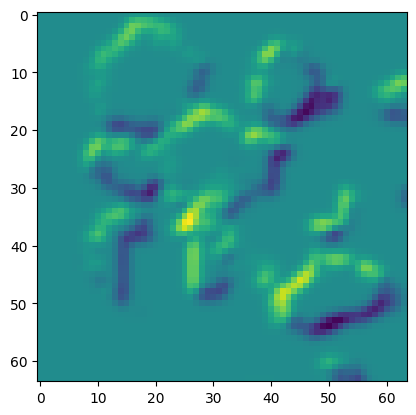

In [100]:
sigma = 1.0  # std deviation
theta = np.pi / 4  # rotation around z-axis
phi = np.pi / 6    # rotation around y-axis

# apply to label image
filtered_image = steerable_filter_3d(label, sigma, theta, phi)
plt.imshow(filtered_image[30,...], cmap='viridis')

# 3d steerable filter with a spherical harmonic basis
brief steps are:

1. define spherical harmonic basis (```compute_spherical_harmonics```)
2. project 3d gaussians to the new coordinate basis 
3. linear combination of basis vectors


In [108]:
import numpy as np
from scipy.special import sph_harm
from scipy.ndimage import convolve

eps = 1e-9

def compute_spherical_harmonics(l, m, theta, phi):
    # compute harmonics of degree l, order m at (theta, phi)
    return sph_harm(m, l, phi, theta)

def spherical_to_cartesian(r, theta, phi):
    # convert spherical to cartesian coordinates
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return x, y, z

def create_grid(size):
    # create a grid of 3d spherical coordinates
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy, zz = np.meshgrid(ax, ax, ax, indexing='ij')
    r = np.sqrt(xx**2 + yy**2 + zz**2)
    theta = np.arccos(np.clip(zz / r, -1, 1)) # ensure numerical stability
    phi = np.arctan2(yy, xx)
    return r, theta, phi

def spherical_harmonic_steerable_filter(size, sigma, l, m):
    r, theta, phi = create_grid(size)
    # we care about the real component of the harmonic
    harmonic_basis = compute_spherical_harmonics(l=l, m=m, theta=theta, phi=phi).real
    gaussian = gaussian_filter(np.exp(-(r**2)/(2*sigma**2)), sigma)
    projected_gaussian = harmonic_basis * gaussian # project gaussians to a spherical harmonic basis
    
    return projected_gaussian

def apply_steerable_filter(image, steerable_filter):
    filtered_image = convolve(image, steerable_filter)
    return filtered_image

In [125]:
sh = steerable_filter.shape
dilated_shape = tuple(2 * dim for dim in sh)
dilated = np.zeros(dilated_shape, dtype=steerable_filter.dtype)
dilated[::2, ::2, ::2] = steerable_filter

In [127]:
dilated.shape

(128, 128, 128)

In [ ]:
filtered_image_dilated = apply_steerable_filter(image, dilated)
plt.imshow(filtered_image_dilated[20,...])

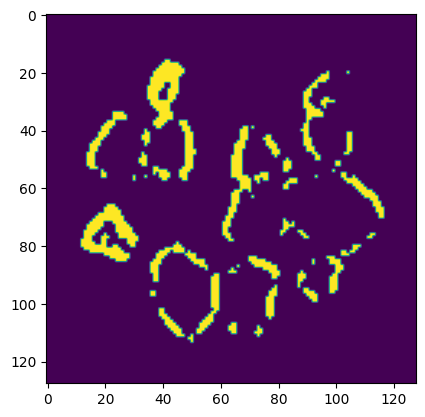

In [110]:
grid_size = 64  # define homogenous sampling grid size
l, m = 2, 1  # degree and order of the spherical harmonic
sigma = 1.0  # std dev of gaussian

steerable_filter = spherical_harmonic_steerable_filter(size=grid_size, sigma=sigma, l=l, m=m)

# convolve label with harmonic basis filter
filtered_image = apply_steerable_filter(image, steerable_filter)

# view convolved image
plt.imshow(filtered_image[20,:,:,])

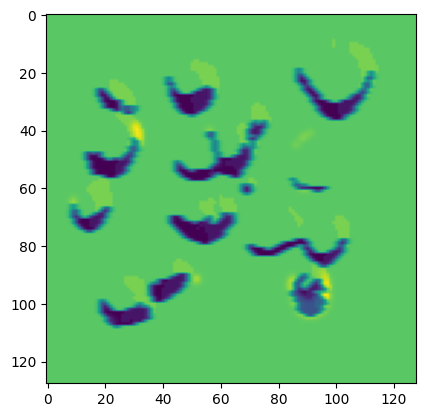

In [114]:
im = nib.load(f'/om2/user/ckapoor/generative_model_steerable_gaussians/outputs/initial_labels/stack_0001.nii.gz').get_fdata()
plt.imshow(im[40,...])

Text(0.5, 1.0, 'perlin x gmm label, slice 40')

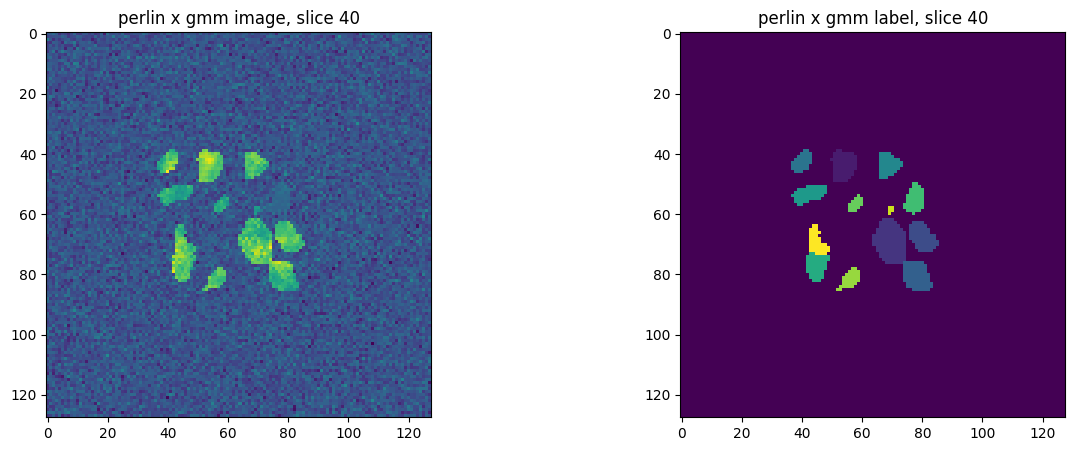

In [118]:
# gmm x perlin without steerable gaussians
perlin_im = nib.load(f'/om2/user/ckapoor/generative_model/outputs/gmm_perlin_images/stack_0000/stack_0000_0005.nii.gz').get_fdata()
perlin_label = nib.load(f'/om2/user/ckapoor/generative_model/outputs/gmm_perlin_labels/stack_0000/stack_0000_0005.nii.gz').get_fdata()

view_sl = 40
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(perlin_im[view_sl,...])
ax[0].set_title(f"perlin x gmm image, slice {view_sl}")
ax[1].imshow(perlin_label[view_sl,...])
ax[1].set_title(f"perlin x gmm label, slice {view_sl}")

In [120]:
np.unique(perlin_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54.])

Text(0.5, 1.0, 'perlin x gmm label, slice 40')

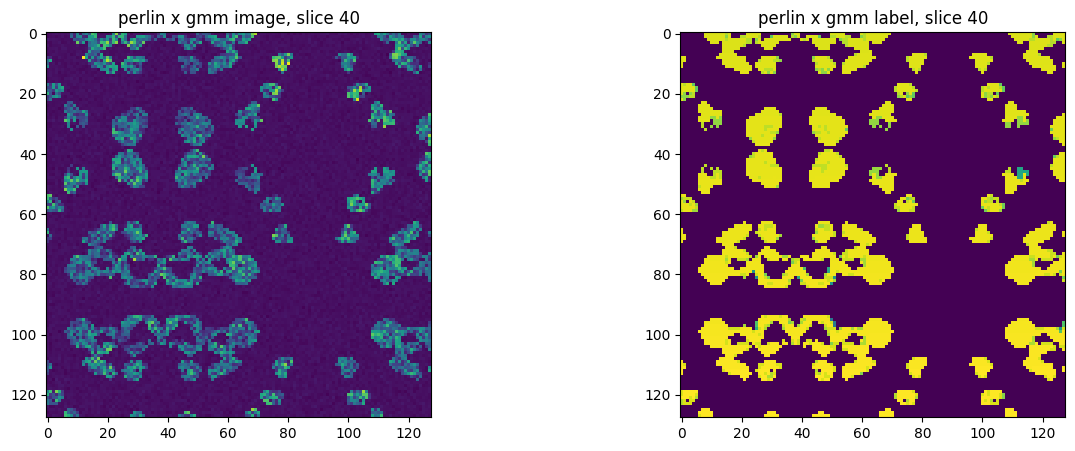

In [121]:
# display gmm x perlin images + labels
perlin_im = nib.load(f'/om2/user/ckapoor/generative_model_steerable_gaussians/outputs/gmm_perlin_images/stack_0000/stack_0000_0005.nii.gz').get_fdata()
perlin_label = nib.load(f'/om2/user/ckapoor/generative_model_steerable_gaussians/outputs/gmm_perlin_labels/stack_0000/stack_0000_0005.nii.gz').get_fdata()

view_sl = 40
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(perlin_im[view_sl,...])
ax[0].set_title(f"perlin x gmm image, slice {view_sl}")
ax[1].imshow(perlin_label[view_sl,...])
ax[1].set_title(f"perlin x gmm label, slice {view_sl}")

# convolve original image (pre-noise)

In [2]:
# load a test label stack
orig_labels = nib.load(f'/om2/user/ckapoor/generative_model_steerable_gaussians/outputs/initial_labels/stack_0000.nii.gz').get_fdata()

In [4]:
# choose randmode for padding
randmode = np.random.choice(['constant', 'reflect'])
randpad_x = np.random.choice([0, 32, 64, 96])
randpad_y = np.random.choice([0, 32, 64, 96])
randpad_z = np.random.choice([0, 32, 64, 96])

In [5]:
# pad label image
padded_labels = np.pad(
                orig_labels,
                [
                    [randpad_x, randpad_x],
                    [randpad_y, randpad_y],
                    [randpad_z, randpad_z],
                ],
                mode=randmode,
)

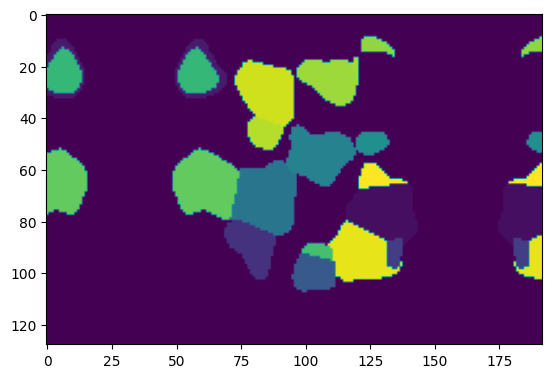

In [6]:
# check a random slice
plt.imshow(padded_labels[64,...])

In [ ]:
# resize label to 128^3
from skimage.transform import resize
curr_labels = resize(padded_labels, (128, 128, 128), preserve_range=True, anti_aliasing=False, order=0)
